In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import association_metrics as am

In [2]:
df=pd.read_csv("Haaland Scoring Data.csv")

In [3]:
df

,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,Start,Pos,Min,Gls,Ast,PK,Opp W,Opp D,Opp L,Match Report
0,23-Mar,Sun,Eliteserien,Regular season,Home,W 5–0,Molde,Sandefjord,N,NaN,25,0,0,0,0,0,0,Match Report
1,23-Mar,Sun,Eliteserien,Regular season,Away,W 1–0,Molde,Haugesund,N,NaN,35,0,0,0,1,0,0,Match Report
2,23-Apr,Sun,Eliteserien,Regular season,Away,L 0–4,Molde,Rosenborg,N,NaN,36,0,0,0,0,2,1,Match Report
3,23-Apr,Sun,Eliteserien,Regular season,Home,W 2–1,Molde,Lillestrøm,Y,FW,90,1,0,1,1,1,2,Match Report
4,23-Apr,Sun,Eliteserien,Regular season,Away,D 0–0,Molde,Vålerenga,Y,FW,82,0,0,0,3,0,2,Match Report
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,12-Nov,Sun,Premier League,Regular season,Away,D 4–4,Manchester City,Chelsea,Y,FW,90,2,1,1,4,3,4,Match Report
241,25-Nov,Sat,Premier League,Regular season,Away,D 1-1,Manchester City,Liverpool,Y,FW,90,1,0,0,8,3,1,NaN
242,28-Nov,Tue,Champions League,Group stage,Home,W 3-2,Manchester City,RB Leipzig,Y,FW,90,1,0,0,3,0,2,NaN
243,3-Dec,Sun,Premier League,Regular season,Home,D 3-3,Manchester City,Tottenham,Y,FW,90,0,1,0,8,2,3,NaN


## Part I: Data Exploration - Context

In [4]:
df["Score?"]=np.where(df["Gls"]>0, "Scored", "Didn't Score")

In [5]:
games_goal=len(df[(df["Score?"]=="Scored")])
games_nogoal=len(df[(df["Score?"]=="Didn't Score")])

print(f"Haaland has scored in {round((games_goal/(games_nogoal+games_goal))*100)}% of the games he has played in the last 5 years.")

Haaland has scored in 56% of the games he has played in the last 5 years.


### Messi Goals First 5 Years

In [6]:
messi_df=pd.read_excel("C:/Users/rprat/OneDrive/Documents/Youtube/When Will Erling Haaland Stop Scoring/Messi Career Stats.xlsx")

In [7]:
messi_df["Score?"]=np.where(messi_df["Gls"]>0, "Scored", "Didn't Score")

In [8]:
games_goal=len(messi_df[(messi_df["Score?"]=="Scored")])
games_nogoal=len(messi_df[(messi_df["Score?"]=="Didn't Score")])

print(f"Messi scored in {round((games_goal/(games_nogoal+games_goal))*100)}% of the games he played in in the first 5 years of his career.")

Messi scored in 39% of the games he played in in the first 5 years of his career.


### Ronaldo Goals First 5 Years

In [9]:
ronaldo_df=pd.read_excel("C:/Users/rprat/OneDrive/Documents/Youtube/When Will Erling Haaland Stop Scoring/Ronaldo Career Stats.xlsx")

In [10]:
ronaldo_df["Score?"]=np.where(ronaldo_df["Gls"]>0, "Scored", "Didn't Score")

In [11]:
games_goal=len(ronaldo_df[(ronaldo_df["Score?"]=="Scored")])
games_nogoal=len(ronaldo_df[(ronaldo_df["Score?"]=="Didn't Score")])

print(f"Ronaldo scored in {round((games_goal/(games_nogoal+games_goal))*100)}% of the games he played in in the first 5 years of his career.")

Ronaldo scored in 20% of the games he played in in the first 5 years of his career.


### When Will He Beat Shearer's Record for All-Time EPL Goalscorer?

In [12]:
epl_df=df[(df["Comp"]=="Premier League")]

In [13]:
epl_games=len(epl_df)
epl_goals=epl_df.Gls.sum()
print("In the Premier League, Haaland scores a goal every", str(epl_games/epl_goals),"games")

In the Premier League, Haaland scores a goal every 1.0 games


In [14]:
games_to_record=round(260*(epl_games/epl_goals))
print("He will reach Shearer's record of 260 EPL goals in", str(games_to_record),"games")
print("Haaland has played", str(epl_games),"games so far. It will take him", str(round((games_to_record-epl_games)/38)),"more seasons to reach the record at this goal rate.")
print("That is", str(441-games_to_record), "games less than it took Alan Shearer")

He will reach Shearer's record of 260 EPL goals in 260 games
Haaland has played 50 games so far. It will take him 6 more seasons to reach the record at this goal rate.
That is 181 games less than it took Alan Shearer


## Part II: Data Cleaning

### Step 1: Reformat data

In [15]:
df["Date"]=df["Date"].str[-3:]

In [16]:
for i in df["Comp"]:
    if i in ["Eliteserien", "Premier League", "Austrian Bundesliga", "Bundesliga"]:
        df["Comp"]=df["Comp"].replace(i, "Domestic League")    
    elif i in ["Community Shield", "DFB-Pokal","EFL Cup", "DFL-Supercup", "FA Cup"]:
        df["Comp"]=df["Comp"].replace(i, "Domestic Cup")    
    elif i in ["Champions League", "Europa League", "UEFA Super Cup"]:
        df["Comp"]=df["Comp"].replace(i, "European Club Competition")

In [17]:
for i in df["Round"]:
    if i in ["Round of 16", "Quarter-finals", "Semi-finals", "Fourth round", "Round of 64", "First round"]:
        df["Round"]=df["Round"].replace(i, "Knockouts") 

In [18]:
df["Competition"]=df["Comp"]+" "+df["Round"]

In [19]:
df["Opponent Form"]=df["Opp W"]-df["Opp L"]+df["Opp D"]*0.5
df["Opponent Form"]=df["Opponent Form"].astype(float)

In [20]:
df["Competition"]=df["Competition"].replace("International Friendly International Friendly", "International Friendly")

In [21]:
df_original=df.copy()

In [22]:
df.drop(columns=["Comp", "Round", "Result","Squad","Opponent","Pos","Min","Gls","Ast","PK","Opp W", "Opp D", "Opp L", "Match Report"], inplace=True)

In [23]:
df

,Date,Day,Venue,Start,Score?,Competition,Opponent Form
0,Mar,Sun,Home,N,Didn't Score,Domestic League Regular season,0.0
1,Mar,Sun,Away,N,Didn't Score,Domestic League Regular season,1.0
2,Apr,Sun,Away,N,Didn't Score,Domestic League Regular season,0.0
3,Apr,Sun,Home,Y,Scored,Domestic League Regular season,-0.5
4,Apr,Sun,Away,Y,Didn't Score,Domestic League Regular season,1.0
...,...,...,...,...,...,...,...
240,Nov,Sun,Away,Y,Scored,Domestic League Regular season,1.5
241,Nov,Sat,Away,Y,Scored,Domestic League Regular season,8.5
242,Nov,Tue,Home,Y,Scored,European Club Competition Group stage,1.0
243,Dec,Sun,Home,Y,Didn't Score,Domestic League Regular season,6.0


## Part III: Model Development

### Step 1: Prepare Data for Computation

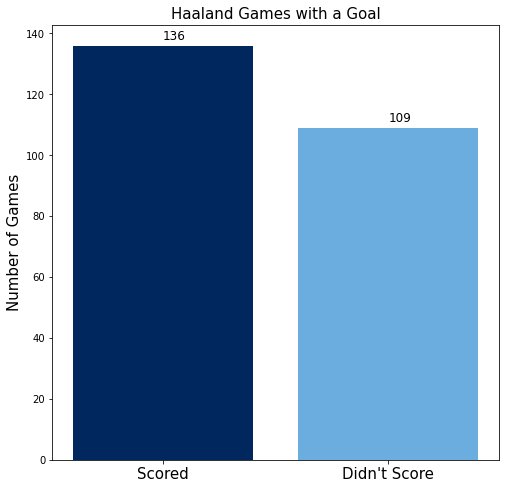

In [24]:
df["Score?"].value_counts()

scored_counts_dict=dict(df["Score?"].value_counts())
scored=list(scored_counts_dict.keys())
counts=list(scored_counts_dict.values())

fig, ax=plt.subplots(figsize=(8,8))
plt.bar(scored[0], counts[0],  color='#00285e')
plt.bar(scored[1], counts[1],  color='#6caddf')
plt.ylabel("Number of Games",fontsize=15)
plt.xticks(fontsize=15)
plt.title("Haaland Games with a Goal", fontsize=15)

for i in scored:
    plt.text(x=i, y=scored_counts_dict[i]+2, s=scored_counts_dict[i], fontsize=12)


The data is imbalanced

In [25]:
df['Score?'] = df['Score?'].map({'Scored': 1, "Didn't Score": 0})

In [26]:
#Balance target data
from sklearn.utils import resample

df_majority = df[(df['Score?']==1)] 
df_minority = df[(df['Score?']==0)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 136, # to match majority class
                                 random_state=42)  # reproducible results

df = pd.concat([df_minority_upsampled, df_majority])

In [27]:
df['Score?'].value_counts()

1    136
0    136
Name: Score?, dtype: int64

The data is balanced

In [28]:
x=df.drop("Score?",axis=1)
predictors=x
y=df["Score?"]

In [29]:
categorical_features=x[["Date", "Venue", "Start", "Competition"]]
categorical_features

,Date,Venue,Start,Competition
230,Sep,Away,Y,Domestic League Regular season
109,Mar,Away,Y,World Cup Qualifying
211,May,Away,Y,European Club Competition Knockouts
21,Aug,Home,N,Domestic League Regular season
238,Nov,Home,Y,Domestic League Regular season
...,...,...,...,...
237,Oct,Away,Y,Domestic League Regular season
239,Nov,Home,Y,European Club Competition Group stage
240,Nov,Away,Y,Domestic League Regular season
241,Nov,Away,Y,Domestic League Regular season


In [30]:
encoder=OneHotEncoder(handle_unknown="ignore")

In [31]:
#Encode dates
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Date"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day","Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep']

In [32]:
#Encode days
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Day"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day", "Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [33]:
#Encode venues
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Venue"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day","Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',"Away","Home","Neutral"]

In [34]:
#Encode start
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Start"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day","Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',"Away","Home","Neutral","N","Y"]

In [35]:
#Encode competitions
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Competition"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day", "Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',"Away","Home","Neutral","N","Y",'Domestic Cup Final', 'Domestic Cup Knockouts',
          'Domestic League Regular season','European Club Competition Final','European Club Competition Group stage','European Club Competition Qualifying',
          "European Club Competition Knockouts",'International Friendly', 'UEFA Euros Qualifying','UEFA Nations League Group stage','World Cup Qualifying']

In [36]:
x=x.drop(columns=["Date","Day","Venue", "Start", "Competition"])
finaltest=pd.DataFrame(x.iloc[-1]).transpose()
feature_names=x

In [37]:
scaler=StandardScaler()
#x=scaler.fit_transform(x)

In [38]:
#finaltest_std=x.iloc[-1]
x=x.iloc[:-1]
y=y.iloc[:-1]

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Trial 1: Logistic Regression

In [40]:
model=LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [41]:
#Logistic Rgeression hyperparameter tuning
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.686508 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.683333 (0.095611) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.686508 (0.095003) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.683333 (0.095611) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.678644 (0.097211) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.678644 (0.097211) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.678644 (0.097211) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.669336 (0.094967) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.669336 (0.094967) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.672511 (0.094824) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.641775 (0.097194) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.641775 (0.097194) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.646392 (0.097709) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.629582 (0.106075) with: {

C:\Users\rprat\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
#Train
lr_model=LogisticRegression(penalty="l2", solver="lbfgs",C=100)
lr_model.fit(x_train, y_train)

C:\Users\rprat\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100)

In [43]:
lr_predictions=lr_model.predict(x_test)

In [44]:
#Evaluate
from sklearn import metrics
lr_confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_test, lr_predictions, labels=[0,1]), index=['True No Score', 'True  Score'], columns=['Predicted No Score', 'Predicted Score'])
lr_confusion_matrix

,Predicted No Score,Predicted Score
True No Score,12,17
True Score,8,18


In [45]:
lr_accuracy=metrics.accuracy_score(y_test, lr_predictions)
lr_precision=metrics.precision_score(y_test, lr_predictions)
lr_recall=metrics.recall_score(y_test, lr_predictions)
lr_f1=metrics.f1_score(y_test, lr_predictions)

In [46]:
lr_scores = cross_val_score(lr_model, x_train, y_train, cv=5, scoring='accuracy')

lr_mean_accuracy = lr_scores.mean()
std_accuracy = lr_scores.std()

C:\Users\rprat\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rprat\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [47]:
lr_performance_summary=pd.DataFrame([lr_accuracy,lr_precision,lr_recall,lr_f1,lr_mean_accuracy],index=["Accuracy","Precision","Recall","F1", "5-Fold CV Mean Accuracy"],columns=["Logistic Regression"])
lr_performance_summary

,Logistic Regression
Accuracy,0.545455
Precision,0.514286
Recall,0.692308
F1,0.590164
5-Fold CV Mean Accuracy,0.666702


### Trial 2: Random Forest Classifier

In [48]:
from sklearn.ensemble import RandomForestClassifier
rfc_model=RandomForestClassifier(random_state=42)
rfc_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
#Random Forest hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [3, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=rfc_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Perform the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [50]:
best_params

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [51]:
rfc_predictions=best_rf_classifier.predict(x_test)

In [52]:
#Evaluate
rfc_confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_test, rfc_predictions, labels=[0,1]), index=['True No Score', 'True  Score'], columns=['Predicted No Score', 'Predicted Score'])
rfc_confusion_matrix

,Predicted No Score,Predicted Score
True No Score,15,14
True Score,8,18


In [53]:
rfc_accuracy=metrics.accuracy_score(y_test, rfc_predictions)
rfc_precision=metrics.precision_score(y_test, rfc_predictions)
rfc_recall=metrics.recall_score(y_test, rfc_predictions)
rfc_f1=metrics.f1_score(y_test, rfc_predictions)

In [54]:
rfc_scores = cross_val_score(best_rf_classifier, x_train, y_train, cv=5, scoring='accuracy')

rfc_mean_accuracy = rfc_scores.mean()
std_accuracy = rfc_scores.std()

In [55]:
rfc_performance_summary=pd.DataFrame([rfc_accuracy,rfc_precision,rfc_recall,rfc_f1,rfc_mean_accuracy],index=["Accuracy","Precision","Recall","F1", "5-Fold CV Mean Accuracy"],columns=["Random Forest Classifier"])
rfc_performance_summary

,Random Forest Classifier
Accuracy,0.600000
Precision,0.562500
Recall,0.692308
F1,0.620690
5-Fold CV Mean Accuracy,0.713636


### Trial 3: SVC

In [56]:
from sklearn.svm import SVC
svc_model=SVC()
svc_model.fit(x_train, y_train)

SVC()

In [57]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(svc_model, param_grid, refit = True, verbose = 3) 

grid.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid.best_params_
best_svc = grid.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.488 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.512 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.512 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.512 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.488 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.581 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.442 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.512 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [58]:
svc_predictions = grid.predict(x_test) 

In [59]:
#Evaluate
svc_confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_test, svc_predictions, labels=[0,1]), index=['True No Score', 'True  Score'], columns=['Predicted No Score', 'Predicted Score'])
svc_confusion_matrix

,Predicted No Score,Predicted Score
True No Score,15,14
True Score,6,20


In [60]:
svc_accuracy=metrics.accuracy_score(y_test, svc_predictions)
svc_precision=metrics.precision_score(y_test, svc_predictions)
svc_recall=metrics.recall_score(y_test, svc_predictions)
svc_f1=metrics.f1_score(y_test, svc_predictions)

In [61]:
svc_scores = cross_val_score(svc_model, x_train, y_train, cv=5, scoring='accuracy')

svc_mean_accuracy = svc_scores.mean()
std_accuracy = svc_scores.std()

In [62]:
svc_performance_summary=pd.DataFrame([svc_accuracy,svc_precision,svc_recall,svc_f1,svc_mean_accuracy],index=["Accuracy","Precision","Recall","F1", "5-Fold CV Mean Accuracy"],columns=["Support Vector Classification"])
svc_performance_summary

,Support Vector Classification
Accuracy,0.636364
Precision,0.588235
Recall,0.769231
F1,0.666667
5-Fold CV Mean Accuracy,0.578647


### Trial 4: XGBoost

In [63]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier().fit(x_train, y_train)
xgb_predictions = xgb_model.predict(x_test)

In [64]:
xgb_confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_test, xgb_predictions, labels=[0,1]), index=['True No Score', 'True  Score'], columns=['Predicted No Score', 'Predicted Score'])
xgb_confusion_matrix

,Predicted No Score,Predicted Score
True No Score,19,10
True Score,9,17


In [65]:
xgb_accuracy=metrics.accuracy_score(y_test, xgb_predictions)
xgb_precision=metrics.precision_score(y_test, xgb_predictions)
xgb_recall=metrics.recall_score(y_test, xgb_predictions)
xgb_f1=metrics.f1_score(y_test, xgb_predictions)

In [66]:
xgb_scores = cross_val_score(xgb_model, x_train, y_train, cv=5, scoring='accuracy')

xgb_mean_accuracy = xgb_scores.mean()
std_accuracy = xgb_scores.std()

In [67]:
xgb_performance_summary=pd.DataFrame([xgb_accuracy,xgb_precision,xgb_recall,xgb_f1,xgb_mean_accuracy],index=["Accuracy","Precision","Recall","F1", "5-Fold CV Mean Accuracy"],columns=["XGBoost"])
xgb_performance_summary

,XGBoost
Accuracy,0.654545
Precision,0.629630
Recall,0.653846
F1,0.641509
5-Fold CV Mean Accuracy,0.653383


## Part IV: Model Selection 

In [68]:
full_performance_summary=pd.merge(lr_performance_summary,rfc_performance_summary,left_index=True, right_index=True, how="inner")
full_performance_summary=pd.merge(full_performance_summary,svc_performance_summary,left_index=True, right_index=True, how="inner")
full_performance_summary=pd.merge(full_performance_summary,xgb_performance_summary,left_index=True, right_index=True, how="inner")
full_performance_summary

,Logistic Regression,Random Forest Classifier,Support Vector Classification,XGBoost
Accuracy,0.545455,0.600000,0.636364,0.654545
Precision,0.514286,0.562500,0.588235,0.629630
Recall,0.692308,0.692308,0.769231,0.653846
F1,0.590164,0.620690,0.666667,0.641509
5-Fold CV Mean Accuracy,0.666702,0.713636,0.578647,0.653383


The Random Forest Classifier is the best performing model, but the Logistic Regression Model will offer us more interpretability

## Part V: Model Interpretation

### Random Forest Classifier

Text(0.5, 1.0, 'Random Forest Feature Importance Ranking')

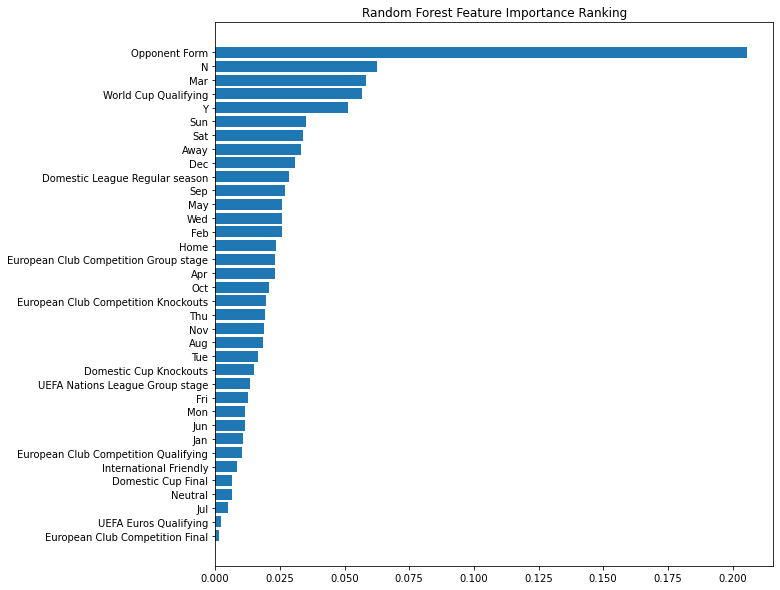

In [69]:
#Feature importances
importances=list(best_rf_classifier.feature_importances_)
features=list(feature_names.columns)

important_feature_dict=dict(zip(features,importances))
important_feature_dict=dict(sorted(important_feature_dict.items(), key=lambda item:item[1]))

features=list(important_feature_dict.keys())
values=list(important_feature_dict.values())
plt.figure(figsize=(10, 10))
plt.barh(features,values)
plt.title("Random Forest Feature Importance Ranking")

In the Random Forest Classifier, the opponent's form is the most important predictor to determine wheter or not Haaland will score

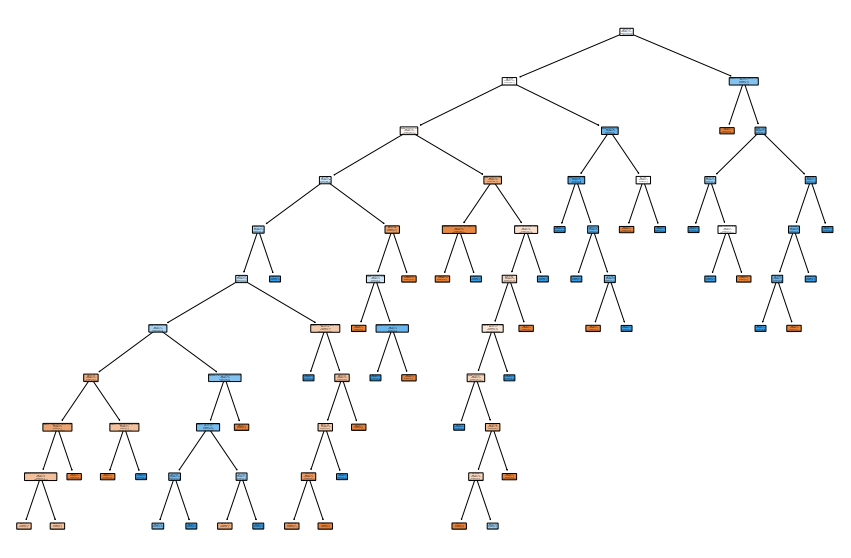

In [70]:
#Sample tree from random forest
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 10))
plot_tree(best_rf_classifier.estimators_[0], filled=True, rounded=True, feature_names=list(feature_names.columns), class_names=["Didn't Score",'Scored'])
plt.show()

In [71]:
print(best_rf_classifier.predict(finaltest))

[1]


The Random Forest predicts Haaland will score in the game against Aston Villa. He did not

### Logistic Regression

In [72]:
coefficients_df=pd.DataFrame(lr_model.coef_, columns=["Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',"Away","Home","Neutral","N","Y",'Domestic Cup Final', 'Domestic Cup Knockouts',
          'Domestic League Regular season','European Club Competition Final','European Club Competition Group stage','European Club Competition Qualifying',
          "European Club Competition Knockouts",'International Friendly', 'UEFA Euros Qualifying','UEFA Nations League Group stage','World Cup Qualifying'])
coefficients_df=coefficients_df.transpose()
coefficients_df=coefficients_df.rename(columns={0:"LR Model Coefficient"})

In [73]:
odds_ratios=[np.exp(x) for x in lr_model.coef_[0]]
odds_impact=[str(round((x-1)*100,2))+"%" for x in odds_ratios]
probabilities=[str(round((x/(1+x))*100,2))+"%" for x in odds_ratios]

In [74]:
coefficients_df["Odds Ratio"]=odds_ratios
coefficients_df["Impact on Odds of Scoring"]=odds_impact
coefficients_df["Probability of Scoring"]=probabilities

In [75]:
coefficients_df

,LR Model Coefficient,Odds Ratio,Impact on Odds of Scoring,Probability of Scoring
Opponent Form,-0.046263,0.954791,-4.52%,48.84%
Apr,-1.689464,0.184619,-81.54%,15.58%
Aug,-1.089158,0.336500,-66.35%,25.18%
Dec,1.585816,4.883276,388.33%,83.0%
Feb,-0.512920,0.598745,-40.13%,37.45%
Jan,-0.865469,0.420854,-57.91%,29.62%
Jul,3.328293,27.890680,2689.07%,96.54%
Jun,1.655989,5.238260,423.83%,83.97%
Mar,-2.964676,0.051577,-94.84%,4.9%
May,-0.685065,0.504057,-49.59%,33.51%


In [76]:
print(lr_model.predict(finaltest))

[1]


The Logistic Regression model predicts Haaland will score in the game against Aston Villa. He did not.

**Interpretation**

Opponent Form: With all other aspects of the game being equal, for every unit increse opponent form, the odds of Haaland scoring decrease by almost 5%

Start Y/N: With all other aspects of the game being equal, the odds of Haaland scoring increase by 172.73% if he starts the game vs. if he doesn't start. Considering no other aspects of the game, the probability of Haaland scoring is 73% if he starts, 26% if he doesn't

Venue: With all other aspects of the game being equal, the odds of Haaland scoring decrease by 64% if he plays it away, 62% if he plays at it home, but increase by 600% if he plays it on a neutral. Considering no other aspects of the game, the probability of Haaland scoring is 27% if he plays away, 28% if he plays at home, 88% if he plays on a neutral site.

Date: With all other aspects of the game being equal, the odds of Haaland scoring decrease by 95% if he plays it in March, 
but increase by 255% if he plays it November. Considering no other aspects of the game, the probability of Haaland scoring in March is 5%, and 78% if he plays in November

Day: With all other aspects of the game being equal, the odds of Haaland scoring decrease by 98% if he plays it on a Monday, 
but increase by 350% if he plays it on a Wednesday. Considering no other aspects of the game, the probability of Haaland scoring on a Monday is 1.25%, but 82% if he plays on a Wednesday

Competition: 
International: With all other aspects of the game being equal, the odds of Haaland scoring increase by 22000% if he's playing an International Friendly, but decrease by 99% if he's playing a World Cup Qualifier. Considering no other aspects of the game, the probability of Haaland scoring is 99% in International Friendlies, but 0.19% in World Cup Qualifier.

Club: With all other aspects of the game being equal, the odds of Haaland scoring increase by 268% if he's playing a European Club Competition Group stage, but decrease by 99% if he's playing a European Club Competition Knockouts. Considering no other aspects of the game, the probability of Haaland scoring is 78% in uropean Club Competition Group stage, but 0.25% in European Club Competition Knockouts.

**Conclusion**: Erling Haaland will stop scoring in a European Club Competition Knockout games he doesn't start, playing away in March against an opponent with a strongest, positive form in the competition

## Part VI: Data Exploration Continued - Check Final Conclusion

### Goals by Competition Type 

In [77]:
competitions=list(df["Competition"].unique())
gamescount=[len(df[(df["Competition"]==i)]) for i in competitions]
comp_goal=[len(df[(df["Score?"]==1)&(df["Competition"]==i)]) for i in competitions]
comp_nogoal=[len(df[(df["Score?"]==0)&(df["Competition"]==i)]) for i in competitions]
comp_goalrate=[str(round((comp_goal[i]/(comp_goal[i]+comp_nogoal[i]))*100)) +"% scored" for i in range(len(competitions))]

data={"Competition":competitions,"Games Played": gamescount, "Games Scored":comp_goal,"Game Didn't Score":comp_nogoal,"Scoring Rate":comp_goalrate}

df2=pd.DataFrame(data)
df2=df2.sort_values(by="Games Played", ascending=True)

gamescount=df2["Games Played"].tolist()
competitions=df2["Competition"].tolist()
comp_goal=df2["Games Scored"].tolist()
comp_nogoal=df2["Game Didn't Score"].tolist()
comp_goalrate=df2["Scoring Rate"].tolist()

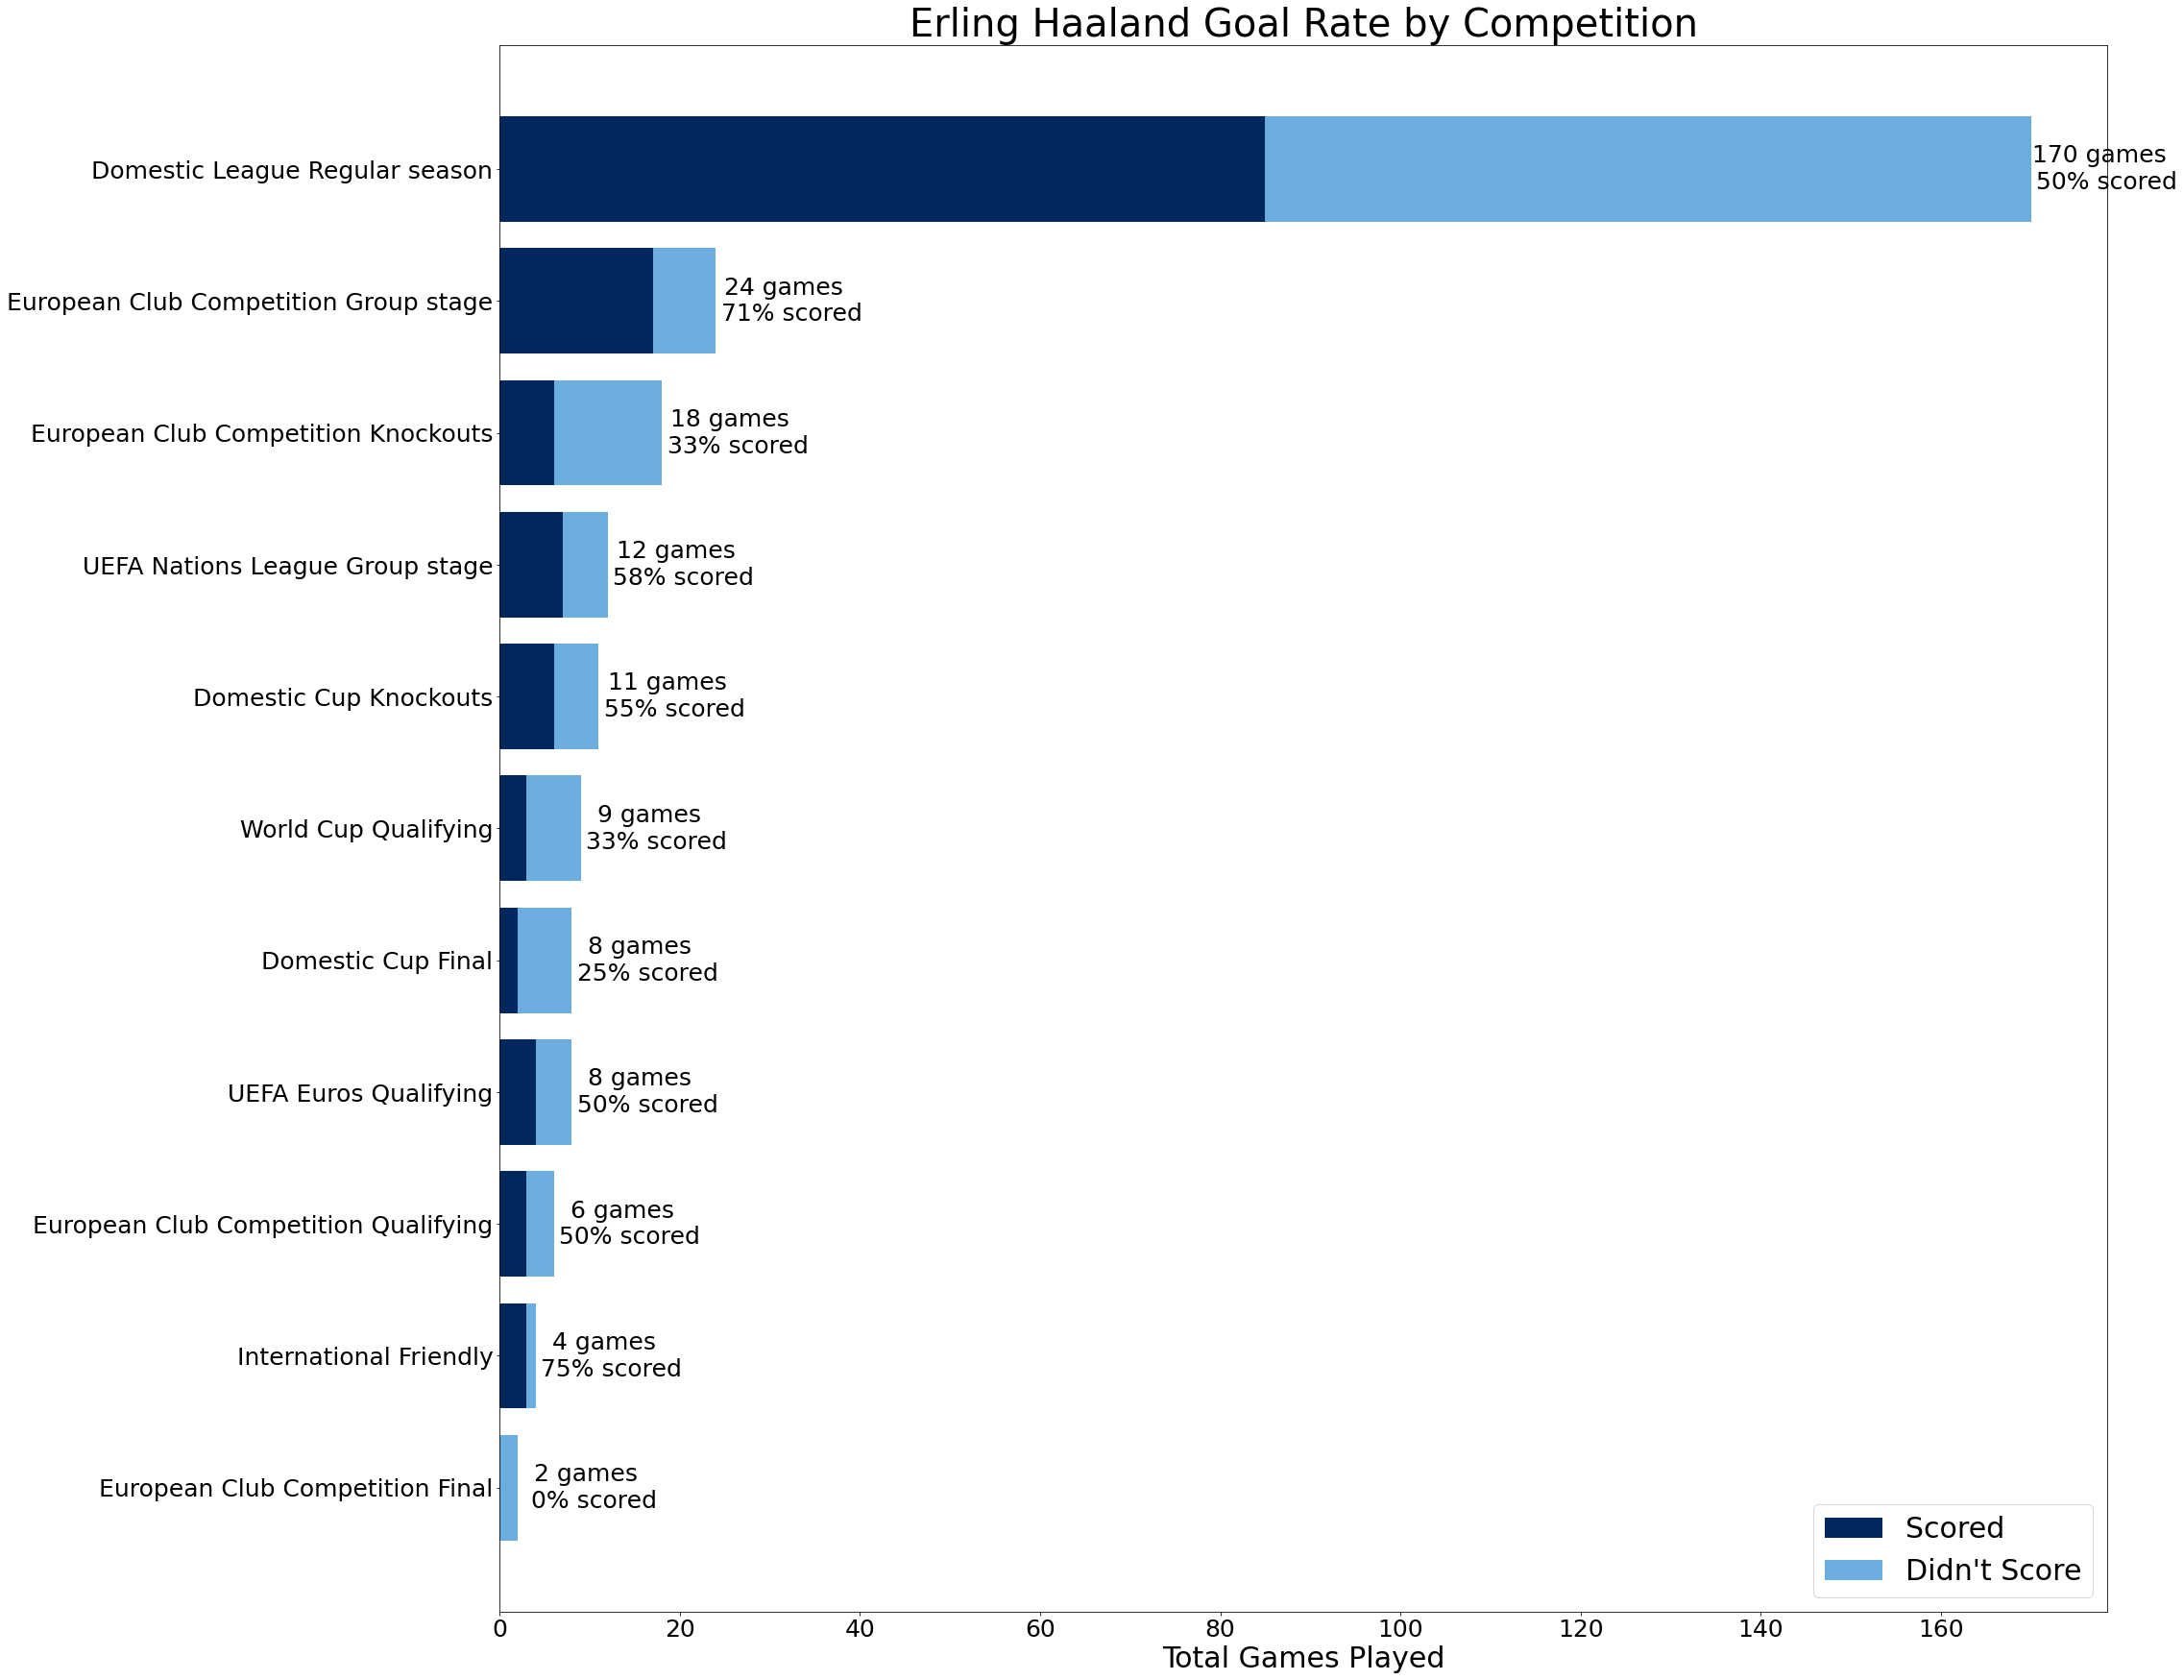

In [78]:
#plt.rcParams['figure.figsize']=[30,25]
fig, ax=plt.subplots(figsize=(30,30))
ax.barh(competitions, comp_goal, color='#00285e')
ax.barh(competitions, comp_nogoal, left=comp_goal, color='#6caddf')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.legend(["Scored","Didn't Score"], fontsize=30, loc= 'lower right')
plt.title("Erling Haaland Goal Rate by Competition", fontsize=40)
plt.xlabel("Total Games Played",fontsize=30)

for i in range(len(comp_goalrate)):
    ax.text(comp_goal[i] + comp_nogoal[i]+8, competitions[i], str(gamescount[i])+ " games \n " +comp_goalrate[i], ha='center', va="center", fontsize=25)

plt.show()

Haaland scores the least in European Club Competition Knockouts, Domestic Cup Finals, and World Cup Qualifiers

### Goals by Start 

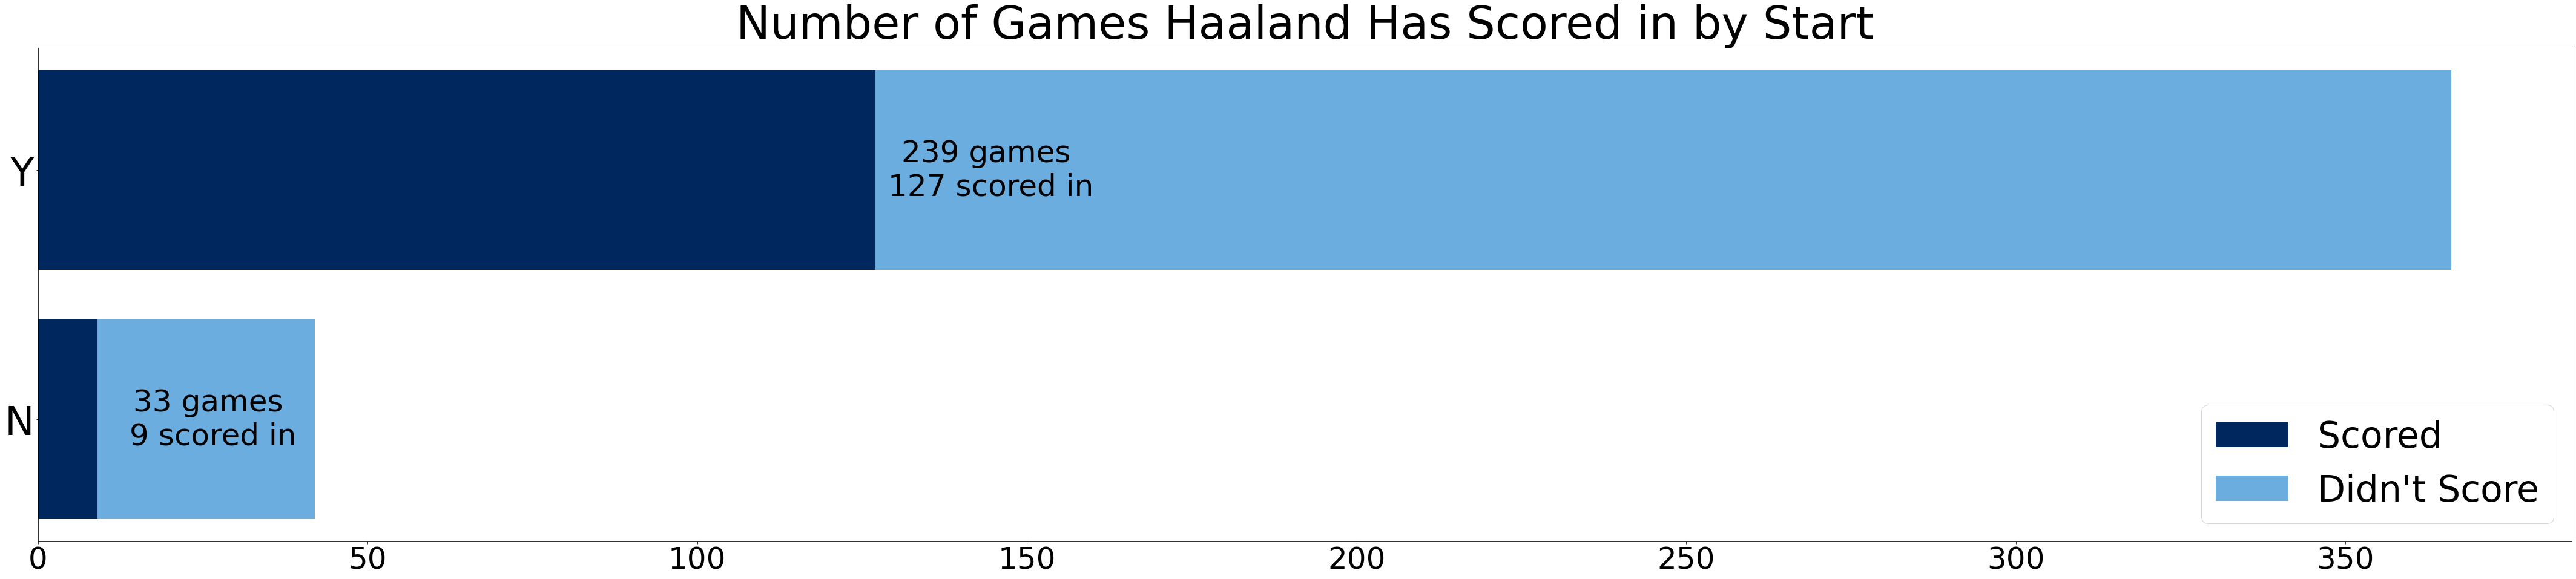

In [79]:
starts=["N", "Y"]
start_goal=[len(df[(df["Score?"]==1)&(df["Start"]==i)]) for i in starts]
start_games=[len(df[(df["Start"]==i)]) for i in starts]

fig, ax=plt.subplots(figsize=(75,15))
ax.barh(starts, start_goal, color='#00285e')
ax.barh(starts, start_games, left=start_goal, color='#6caddf')
plt.yticks(fontsize=65)
plt.xticks(fontsize=50)
ax.legend(["Scored","Didn't Score"], fontsize=60, loc= 'lower right')
for i in range(len(start_goal)):
    ax.text(start_goal[i]+17.5, starts[i], str(start_games[i])+ " games \n"+str(start_goal[i])+" scored in", ha='center', va="center", fontsize=50)
plt.title("Number of Games Haaland Has Scored in by Start", fontsize=75)

plt.show()

93% of Haaland's goals come from having started the game. He has scored in 53% in the games he has started, versus 27% of the games he hasn't

### Goals by Venue

Text(0.5, 1.0, 'Number of Games Haaland Has Scored in by Venue')

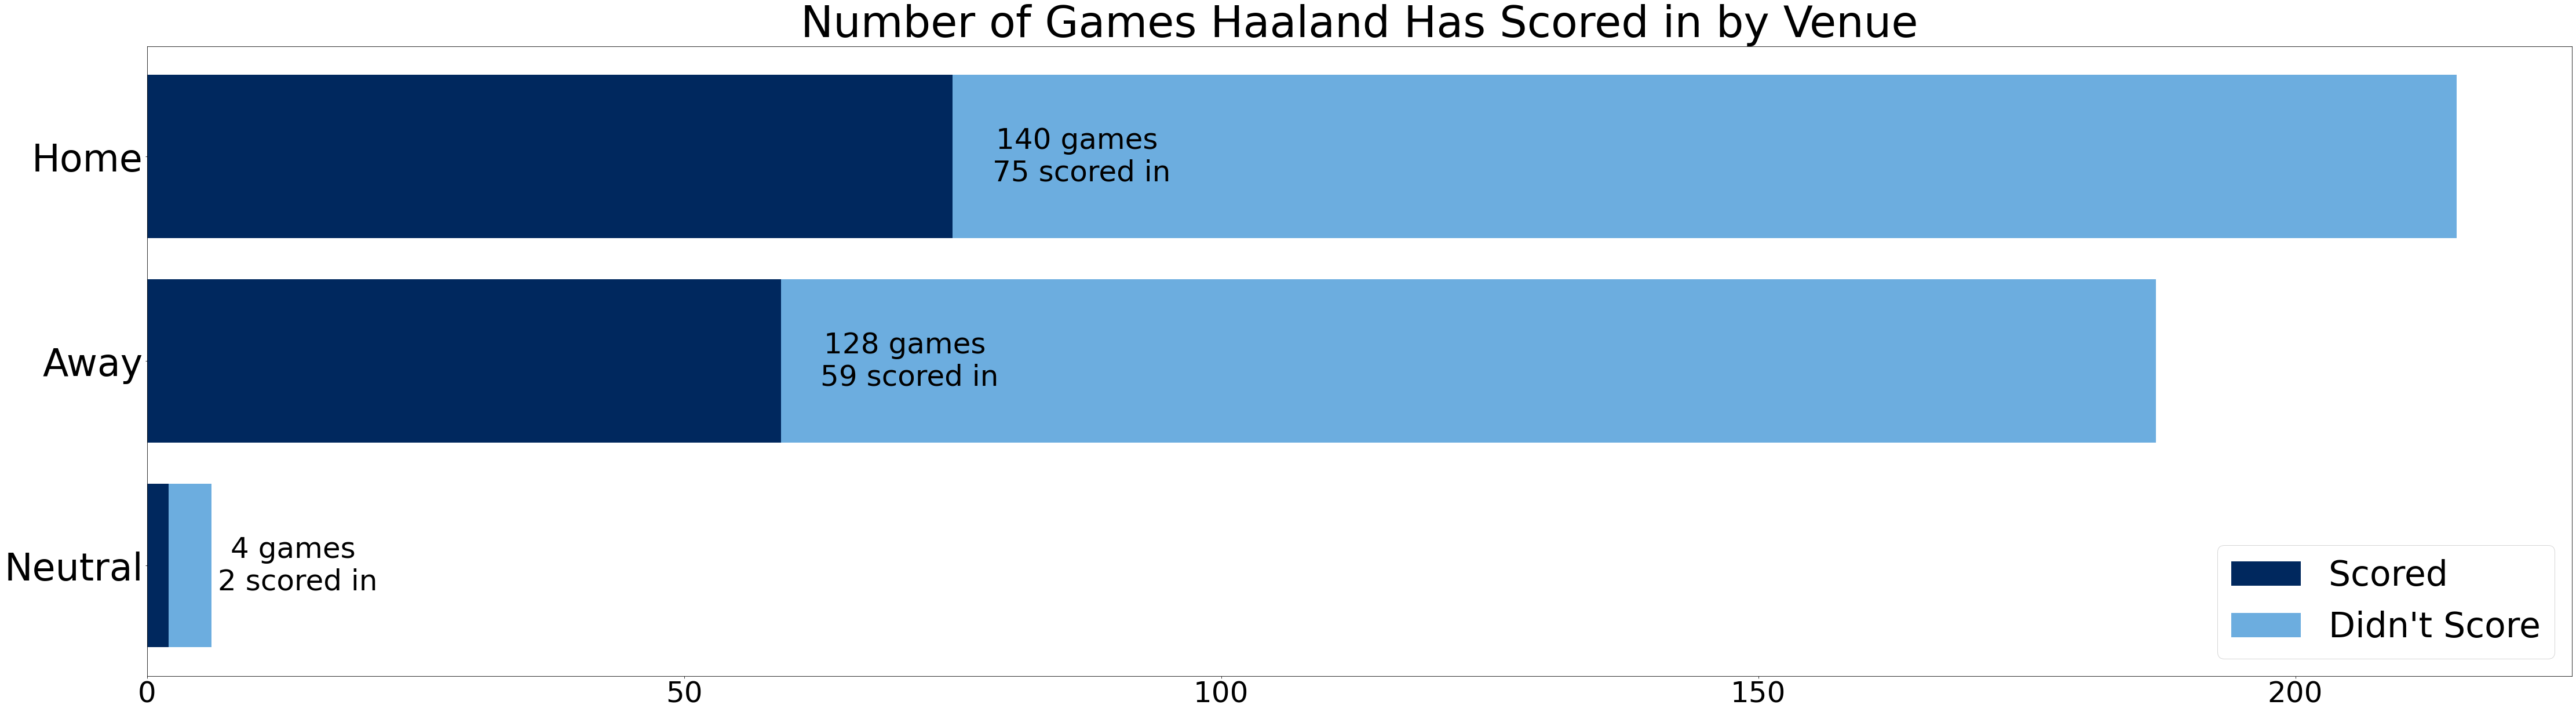

In [80]:
venues=["Neutral", "Away","Home"]
venue_goal=[len(df[(df["Score?"]==1)&(df["Venue"]==i)]) for i in venues]
venue_games=[len(df[(df["Venue"]==i)]) for i in venues]


fig, ax=plt.subplots(figsize=(75,20))
ax.barh(venues, venue_goal, color='#00285e')
ax.barh(venues, venue_games, left=venue_goal, color='#6caddf')
plt.yticks(fontsize=65)
plt.xticks(fontsize=50)
ax.legend(["Scored","Didn't Score"], fontsize=60, loc= 'lower right')

for i in range(len(venue_goal)):
    ax.text(venue_goal[i]+12, venues[i], str(venue_games[i])+ " games \n"+str(venue_goal[i])+" scored in", ha='center', va="center", fontsize=50)
plt.title("Number of Games Haaland Has Scored in by Venue", fontsize=75)

Haaland has scored in over 50% of his games at home and at neutral sites, and 46% of his games away. Venue is not a highly influential feature in determining if he will score

Text(0.5, 1.0, 'Number of Games Haaland Has Scored in by Month')

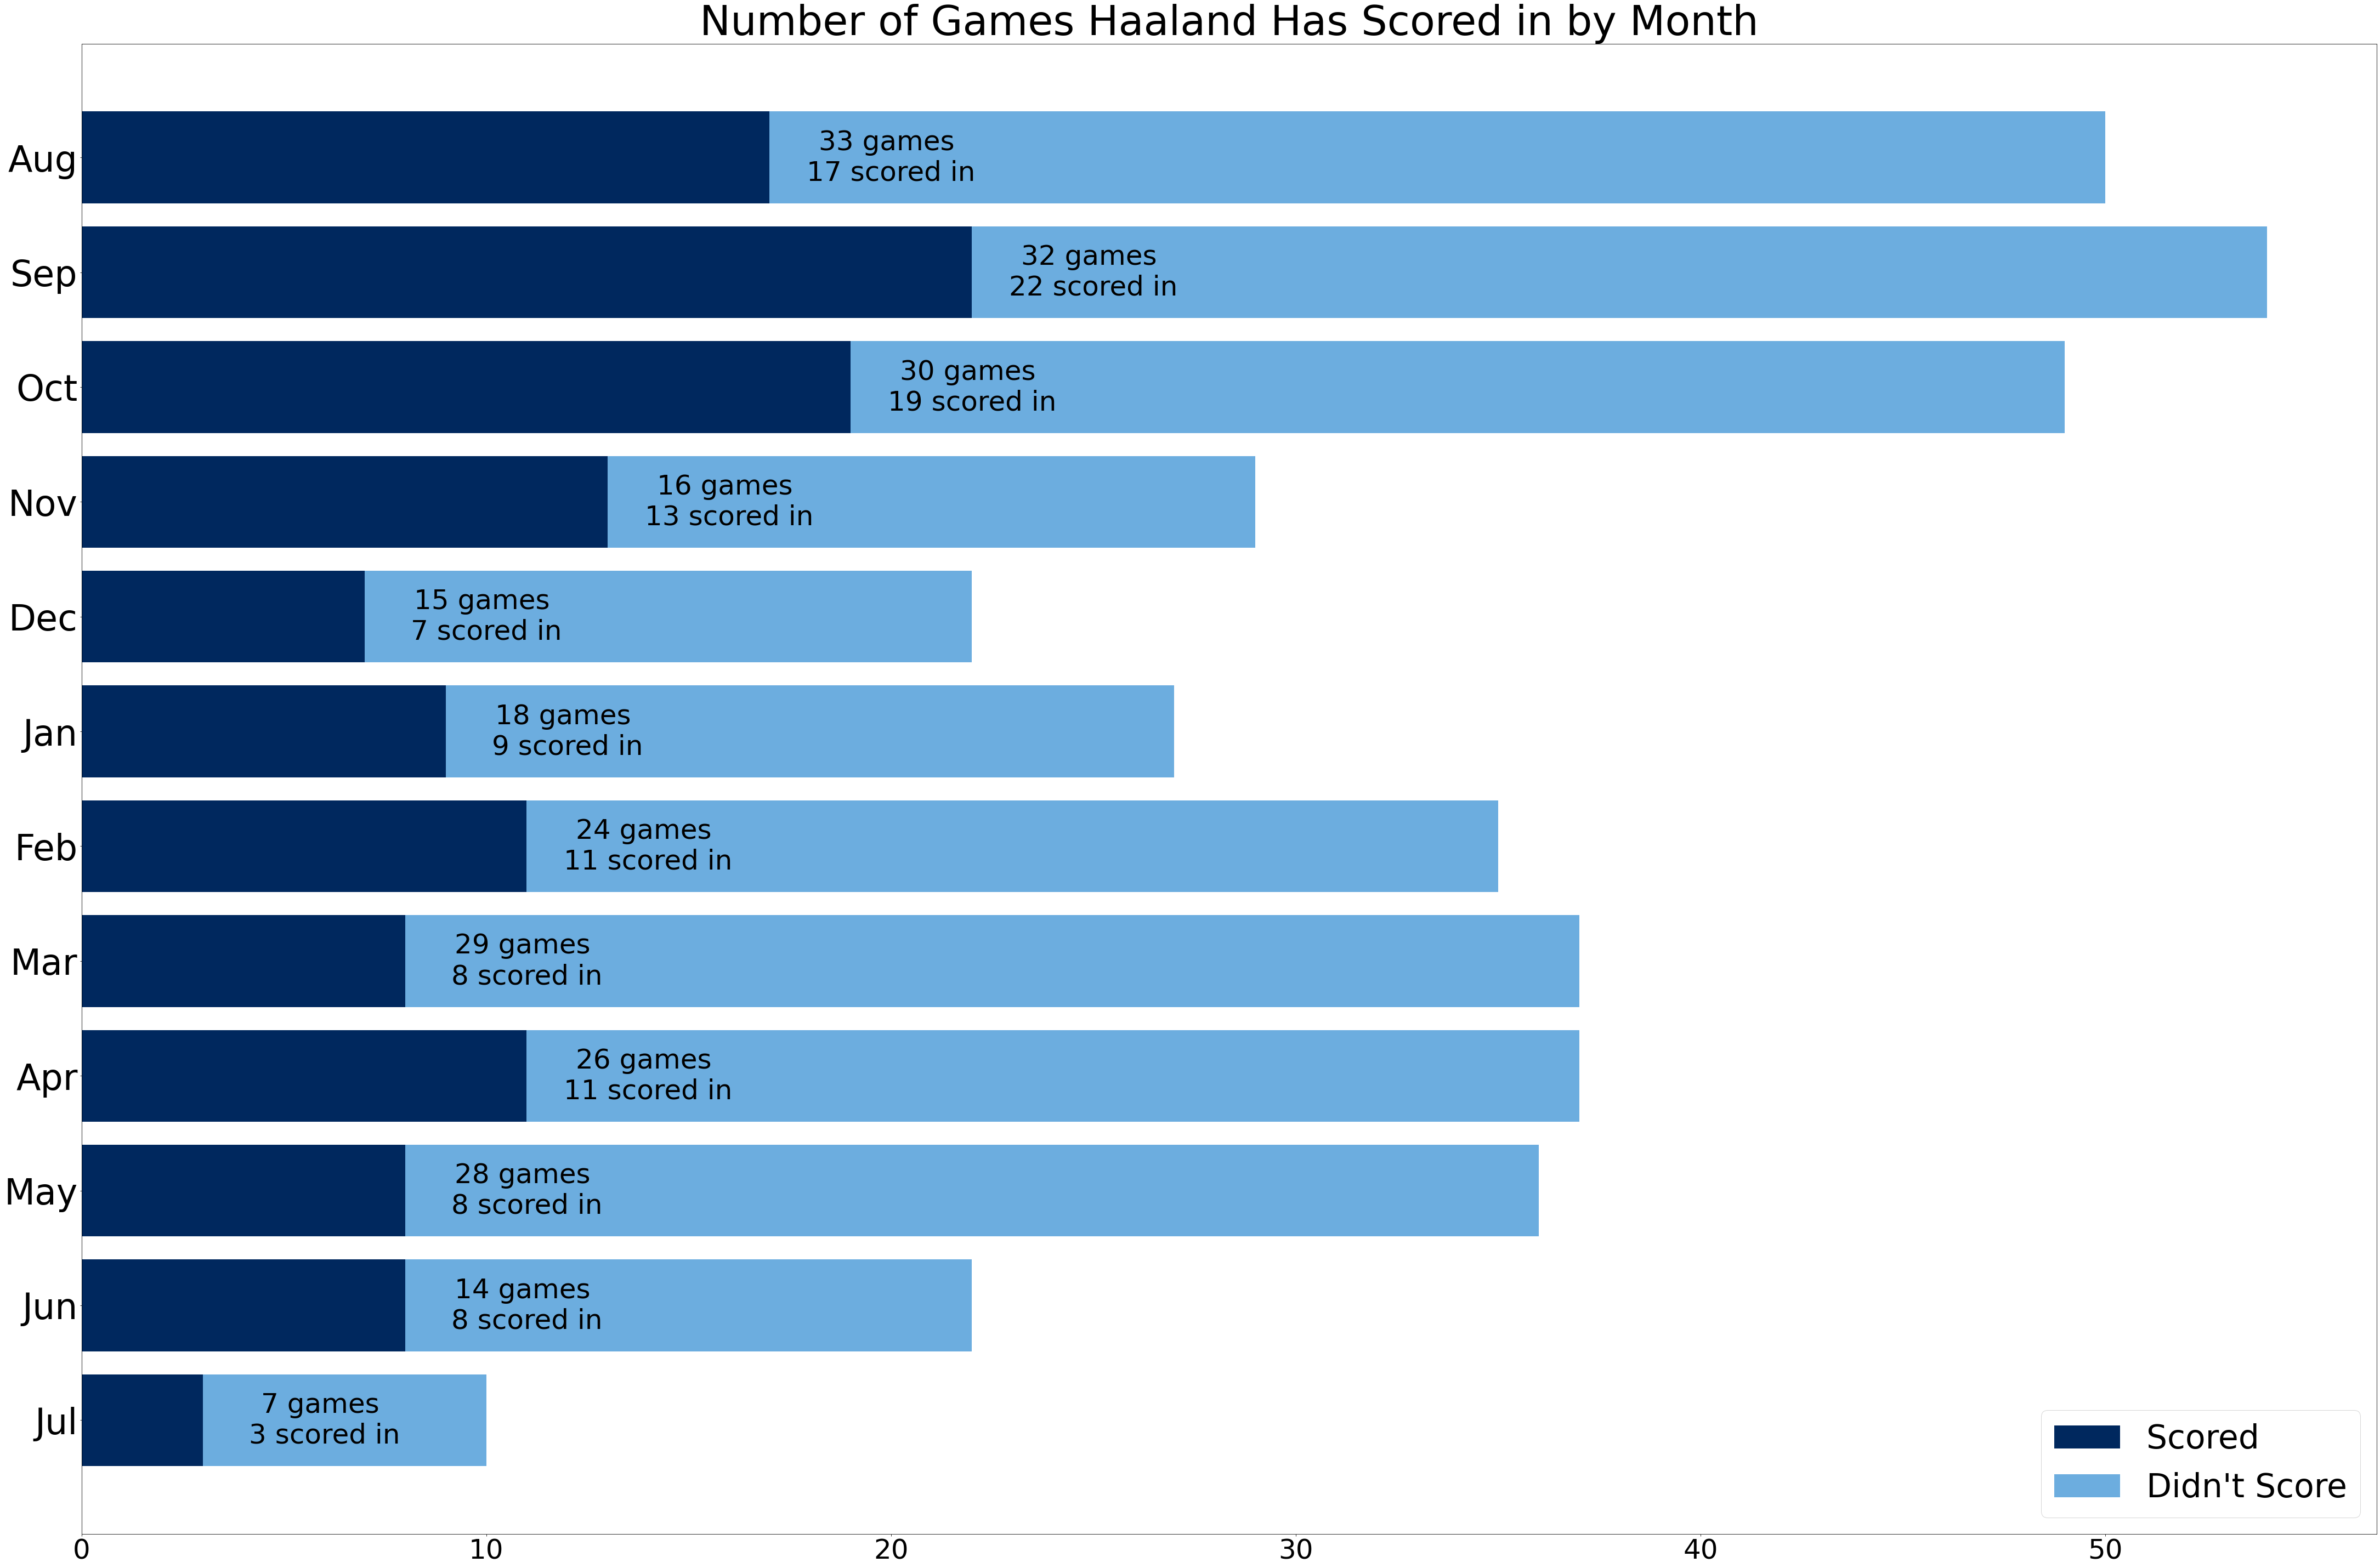

In [81]:
months=["Aug", "Sep","Oct","Nov","Dec","Jan","Feb","Mar","Apr","May","Jun","Jul"]
months.reverse()
month_goal=[len(df[(df["Score?"]==1)&(df["Date"]==i)]) for i in months]
month_games=[len(df[(df["Date"]==i)]) for i in months]


fig, ax=plt.subplots(figsize=(75,50))
ax.barh(months, month_goal, color='#00285e')
ax.barh(months, month_games, left=month_goal, color='#6caddf')
plt.yticks(fontsize=65)
plt.xticks(fontsize=50)
ax.legend(["Scored","Didn't Score"], fontsize=60, loc= 'lower right')

for i in range(len(month_goal)):
    ax.text(month_goal[i]+3, months[i], str(month_games[i])+ " games \n"+str(month_goal[i])+" scored in", ha='center', va="center", fontsize=50)
plt.title("Number of Games Haaland Has Scored in by Month", fontsize=75)

March has Haaland's lowest games-to-goal percentage (27%). Interestingly, his goal tally is strong at the start of the season and tapers off as the season goes. Note that there are very few games played in the month of July

### Goals by Day

Text(0.5, 1.0, 'Number of Games Haaland Has Scored in by Day')

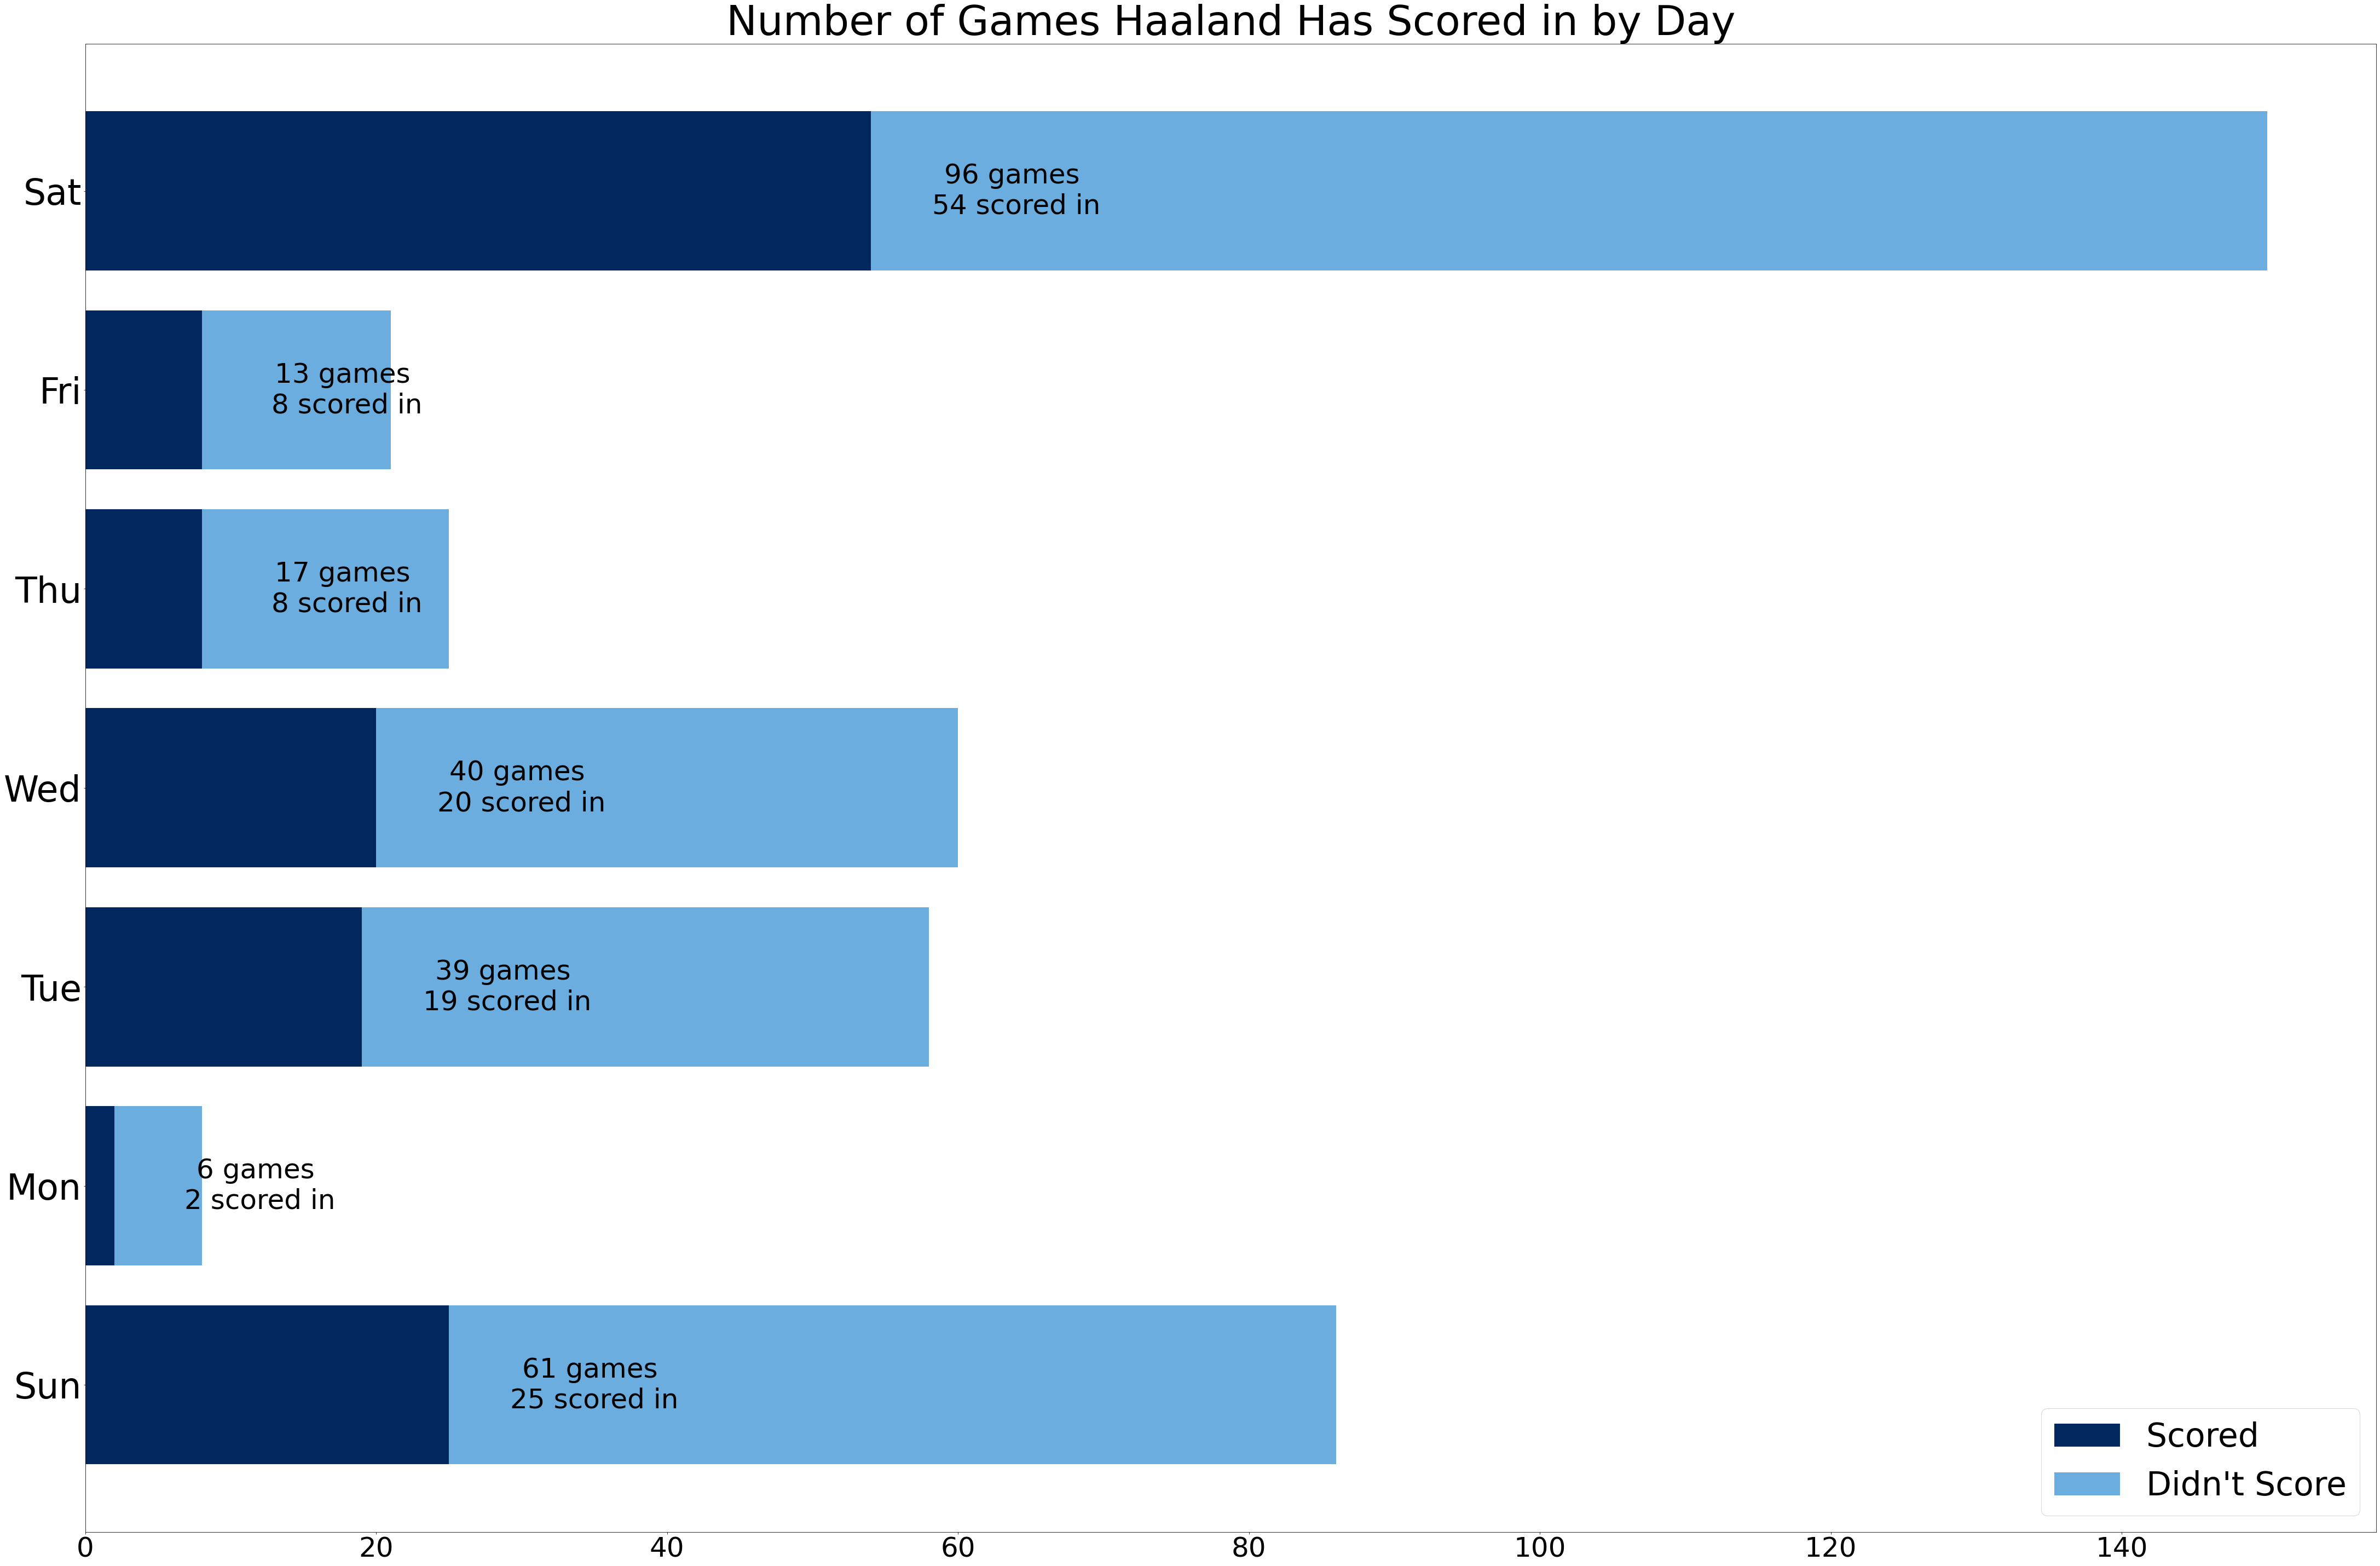

In [82]:
days=["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]
day_goal=[len(df[(df["Score?"]==1)&(df["Day"]==i)]) for i in days]
day_games=[len(df[(df["Day"]==i)]) for i in days]


fig, ax=plt.subplots(figsize=(75,50))
ax.barh(days, day_goal, color='#00285e')
ax.barh(days, day_games, left=day_goal, color='#6caddf')
plt.yticks(fontsize=65)
plt.xticks(fontsize=50)
ax.legend(["Scored","Didn't Score"], fontsize=60, loc= 'lower right')

for i in range(len(day_goal)):
    ax.text(day_goal[i]+10, days[i], str(day_games[i])+ " games \n"+str(day_goal[i])+" scored in", ha='center', va="center", fontsize=50)
plt.title("Number of Games Haaland Has Scored in by Day", fontsize=75)

Haaland scores the least on Mondays

### Goals by Opponent Form

Text(0.5, 1.0, 'Number of Games Haaland Has Scored in by Opponent Form')

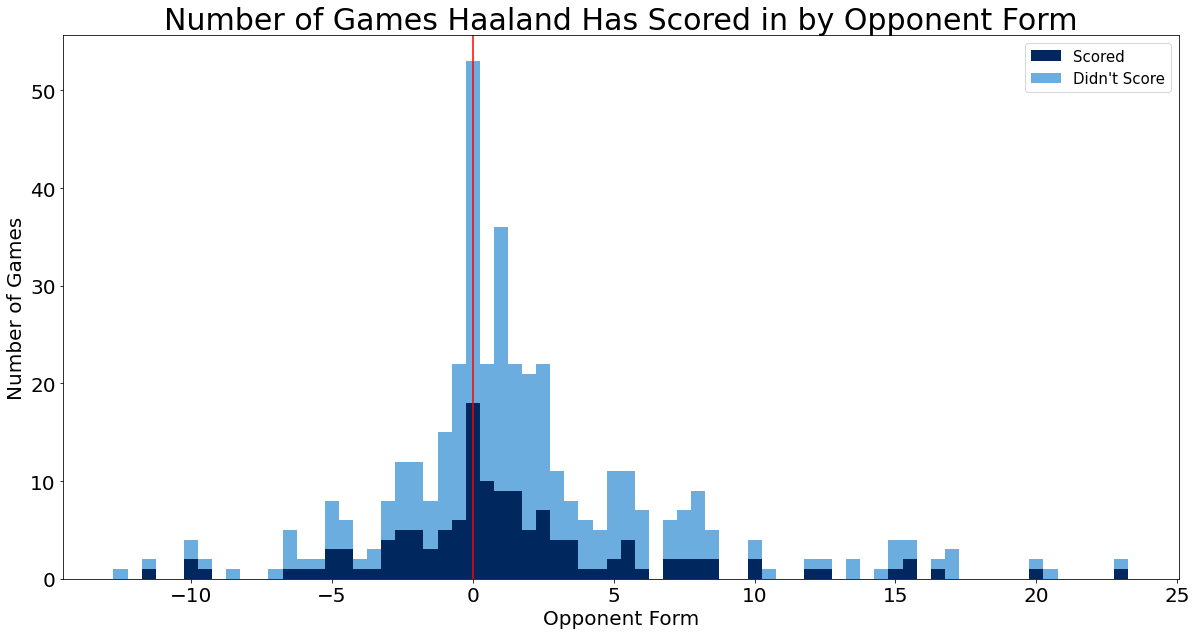

In [84]:
forms=list(df["Opponent Form"].unique())
forms_goal=[len(df[(df["Score?"]==1)&(df["Opponent Form"]==i)]) for i in forms]
forms_games=[len(df[(df["Opponent Form"]==i)]) for i in forms]

fig, ax=plt.subplots(figsize=(20,10))
ax.bar(forms, forms_goal, color='#00285e',width=0.5)
ax.bar(forms, forms_games,bottom=forms_goal, color='#6caddf', width=0.5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel("Opponent Form",fontsize=20)
plt.ylabel("Number of Games",fontsize=20)
plt.legend(["Scored","Didn't Score"], fontsize=15, loc= 'upper right')

plt.axvline(0, color="red")
plt.title("Number of Games Haaland Has Scored in by Opponent Form", fontsize=30)

In [85]:
positive_form_goals=len(df[(df["Score?"]==1)&(df["Opponent Form"]>0)]) 
positive_form_games=len(df[(df["Opponent Form"]>0)])
percent_scored=round((positive_form_goals/positive_form_games)*100)
        
print("Haaland has played "+str(positive_form_games)+" games against opponents with positive form (they have winning record in the game's competition)\nHe scored in "+str(positive_form_goals)+ " of them ("+str(percent_scored)+"%)")

Haaland has played 164 games against opponents with positive form (they have winning record in the game's competition)
He scored in 75 of them (46%)


In [86]:
negative_form_goals=len(df[(df["Score?"]==1)&(df["Opponent Form"]<=0)]) 
form_goals=len(df[(df["Score?"]==1)])
percent_scored=round((negative_form_goals/form_goals)*100)

print(str(percent_scored)+"%  of the goals Haaland has scored has been against opponents with negative form")

45%  of the goals Haaland has scored has been against opponents with negative form


In [91]:
print("The average form of a team Haaland has scored against is "+str(np.mean(df[(df["Score?"]==1)].iloc[:,6].astype(int))))

The average form of a team Haaland has scored against is 1.375


Haaland is more proficient against teams who are slightly in form. The difference in his goal-scoring productivity against teams who are in form is marginally greater than against those who are not

What does this mean for the conclusion of our model? We know Haaland has the lowest goal scoring rate in away games and games played in March. We know European Club Competition Knockouts is one of the competition he scores the least in. We know he has a very low goal scoring rate when he doesn't start the game, and that he is most prolific at scoring against team who have very low positive form

Is there a game that proves our conclusion? Not exactly, but we can find some that are similar

In [88]:
df[(df["Venue"]=="Away")&(df["Competition"]=="European Club Competition Knockouts")]

,Date,Day,Venue,Start,Score?,Competition,Opponent Form
211,May,Tue,Away,Y,0,European Club Competition Knockouts,7.5
65,Mar,Wed,Away,Y,0,European Club Competition Knockouts,4.5
196,Feb,Wed,Away,Y,0,European Club Competition Knockouts,2.0
196,Feb,Wed,Away,Y,0,European Club Competition Knockouts,2.0
211,May,Tue,Away,Y,0,European Club Competition Knockouts,7.5
196,Feb,Wed,Away,Y,0,European Club Competition Knockouts,2.0
196,Feb,Wed,Away,Y,0,European Club Competition Knockouts,2.0
65,Mar,Wed,Away,Y,0,European Club Competition Knockouts,4.5
101,Feb,Wed,Away,Y,1,European Club Competition Knockouts,3.5
205,Apr,Wed,Away,Y,1,European Club Competition Knockouts,7.0


Haaland has played in 10 European Club Competition Knockout away games, he only scored in 2 of them. Neither of them were in March, and he started both of them

In [89]:
df[(df["Venue"]=="Away")&(df["Date"]=="Mar")&(df["Start"]=="N")]

,Date,Day,Venue,Start,Score?,Competition,Opponent Form
1,Mar,Sun,Away,N,0,Domestic League Regular season,1.0
1,Mar,Sun,Away,N,0,Domestic League Regular season,1.0
1,Mar,Sun,Away,N,0,Domestic League Regular season,1.0
1,Mar,Sun,Away,N,0,Domestic League Regular season,1.0


Haaland has played 4 away games in March that he did not start. He didn't score in any of them, even though they were against average form opponents